In [1]:
import tensorflow as tf
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from util import import_dataset

address = '../../data/'
file_names = {}
file_names['images'] = 'full_data.npy'
file_names['subs'] = 'full_subredditlabels'
file_names['dict'] = 'full_subredditIndex'
file_names['nsfw'] = 'full_nsfwlabels'
data, dictionary = import_dataset(address, file_names)

In [3]:
print(data.X_train.shape)
print(data.X_val.shape)
print(data.X_test.shape)
print(data.y_train.shape)
print(data.y_val.shape)
print(data.y_test.shape)

(25450, 128, 128, 3)
(3181, 128, 128, 3)
(3182, 128, 128, 3)
(25450,)
(3181,)
(3182,)


## Run the Model

In [4]:
from googlenet import GoogleNet
from config import ModelConfig, TrainConfig

tf.reset_default_graph()

model_config = ModelConfig(eval_batch_size=512, learning_rate=5e-4, output="subreddit")
train_config = TrainConfig(print_every=100, num_epochs=5, saver_address=r'../../saved_params/', \
    save_file_name = 'GoogleNet_subreddit_classification')
model = GoogleNet(model_config)
sess = tf.Session()
model.train(data, sess, train_config)

---------------------------------------------------------
Batch 100/398 of epoch 1 finished in 34.468862 seconds
Batch 200/398 of epoch 1 finished in 29.194134 seconds
Batch 300/398 of epoch 1 finished in 29.353129 seconds
Epoch 1 training finished in 122.326680 seconds
train accuracy:32.4%
val accuracy:32.0%
Epoch 1 evaluation finished in 37.527616 seconds
---------------------------------------------------------
Batch 100/398 of epoch 2 finished in 29.125393 seconds
Batch 200/398 of epoch 2 finished in 29.241425 seconds
Batch 300/398 of epoch 2 finished in 29.210333 seconds
Epoch 2 training finished in 116.197770 seconds
train accuracy:39.2%
val accuracy:36.8%
Epoch 2 evaluation finished in 32.274051 seconds
---------------------------------------------------------
Batch 100/398 of epoch 3 finished in 29.043039 seconds
Batch 200/398 of epoch 3 finished in 29.211576 seconds
Batch 300/398 of epoch 3 finished in 29.254530 seconds
Epoch 3 training finished in 116.091580 seconds
train acc

## Load Model

In [6]:
from googlenet import GoogleNet
from config import ModelConfig, TrainConfig
import pickle

# Reset Graph
tf.reset_default_graph()

# Create model instance
model_config = ModelConfig(eval_batch_size=512, learning_rate=5e-4, output="subreddit")
model = GoogleNet(model_config)

# Load Saved Model
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "../../saved_params/GoogleNet_subreddit_classification") 
saved_history = pickle.load(open("../../saved_params/GoogleNet_subreddit_classification_modelhist", 'rb'))
model.model_history = saved_history

# Test Model Accuracy
loss_train, acc_train = model.eval(data, sess, split='train')
loss_val, acc_val = model.eval(data, sess, split = 'val')

train accuracy:52.9%
val accuracy:47.4%


## Plot Graphs

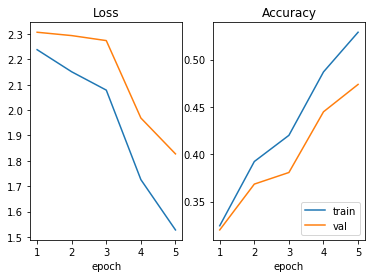

In [18]:
model.plot_loss_acc(data)

In [9]:
# Get model predictions
y_val_pred = sess.run(model.prediction, {model.X_placeholder: data.X_val, model.y_placeholder: data.y_val, 
                                            model.is_training_placeholder:False})

y_val_pred = np.argmax(y_val_pred, axis = 1)

Normalized confusion matrix


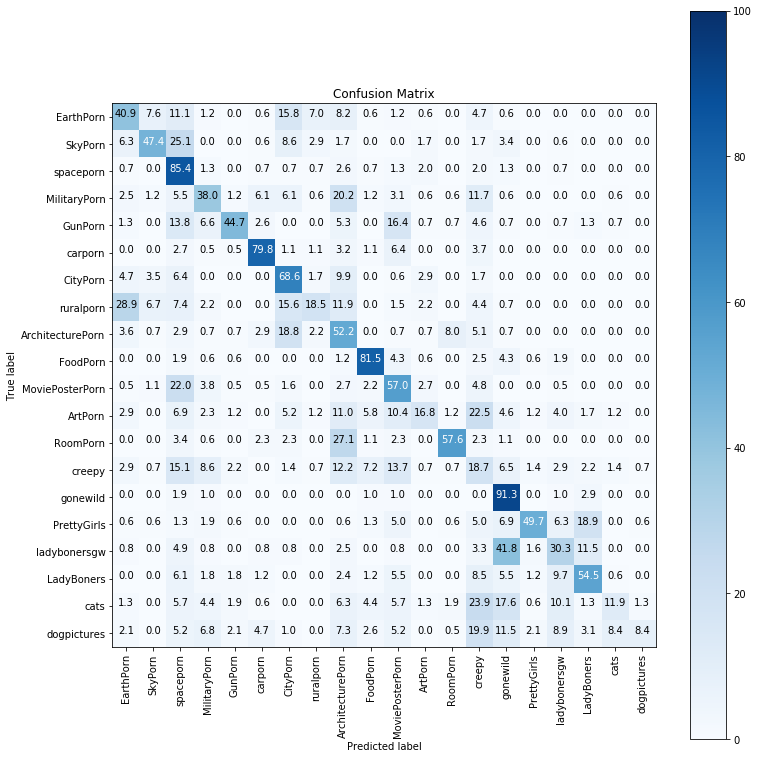

In [10]:
from util import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

classes = sorted(dictionary, key=dictionary.get)
cm = confusion_matrix(data.y_val, y_val_pred)
plot_confusion_matrix(cm, classes, normalize=True)

# Hyperparameter Tuning

In [16]:
import hyperopt as hpropt

def objective(args):
    model_config = ModelConfig(learning_rate=args['learning_rate'], sbrd_weight=args['sbrd_weight'], keep_prob=args['keep_prob'])
    train_config = TrainConfig(num_epochs=args['num_epochs'], lr_decay=args['lr_decay'])
    
    tf.reset_default_graph()
    model = GoogleNet(model_config)
    
    sess = tf.Session()
    model.train(data, sess, train_config)
    cost, accuracy_sbrd, accuracy_nsfw = model.eval(data, sess, "val")
    
    saveList = {
        'accuracy_sbrd' : accuracy_sbrd,
        'accuracy_nsfw' : accuracy_nsfw,
        'cost' : cost,
        'num_epochs' : args['num_epochs'],
        'learning_rate' : args['learning_rate'],
        'lr_decay' : args['lr_decay'],
        'sbrd_weight' : args['sbrd_weight'],
        'keep_prob' : args['keep_prob']
    }    
    pickle.dump(saveList, open("../../hprOpt/" + str(accuracy_sbrd) + "_"  + str(accuracy_nsfw) + "_" + str(cost) + ".dat", "wb"))
    model.plot_loss_acc(data)
    return cost

def optimize(space, max_evals=50):
    
    space = {
        'num_epochs' : hpropt.hp.randint('num_epochs', 20),
        'learning_rate' : hpropt.hp.loguniform('learning_rate', -4, -1),
        'lr_decay' : hpropt.hp.uniform('lr_decay', 0.9, 1.0),
        'sbrd_weight' : hpropt.hp.uniform('sbrd_weight', 0.5, 1.0),
        'keep_prob' : hpropt.hp.uniform('keep_prob', 0.3, 1.0)
    }
    
    best = hpropt.fmin(objective, space, algo=hpropt.tpe.suggest, max_evals=max_evals)
    print(best)
    
    return best

In [17]:
space = {
    'num_epochs' : 1,
    'learning_rate' : hpropt.hp.loguniform('learning_rate', -4, -1),
    'lr_decay' : hpropt.hp.uniform('lr_decay', 0.9, 1),
    'sbrd_weight' : hpropt.hp.uniform('sbrd_weight', 0.5, 1)
}
optimize(space, 2)

---------------------------------------------------------
Batch 100/398 of epoch 1 finished in 32.875108 seconds
Batch 200/398 of epoch 1 finished in 29.467215 seconds
Batch 300/398 of epoch 1 finished in 29.427680 seconds
Epoch 1 training finished in 120.512484 seconds
train accuracy:8.7%
val accuracy:8.4%
Epoch 1 evaluation finished in 50.676418 seconds
---------------------------------------------------------
Batch 100/398 of epoch 2 finished in 29.402927 seconds
Batch 200/398 of epoch 2 finished in 29.513809 seconds
Batch 300/398 of epoch 2 finished in 29.513275 seconds
Epoch 2 training finished in 117.227812 seconds
train accuracy:14.1%
val accuracy:13.9%
Epoch 2 evaluation finished in 34.476176 seconds
---------------------------------------------------------
Batch 100/398 of epoch 3 finished in 29.486961 seconds
Batch 200/398 of epoch 3 finished in 29.464603 seconds
Batch 300/398 of epoch 3 finished in 29.618033 seconds
Epoch 3 training finished in 117.594713 seconds
train accur

KeyboardInterrupt: 